# Growth Rate following Stress

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## Q1: What percent difference in growth rate is detectable following stress in 120 min?

**Model:**

Cell growth is given by the exponential equation $n(t) = n_0e^{rt}$ where $r$ is the instaneous growth rate. For diploid yeast, we know the doubling time is roughly 100 min, corresponding to an instaneous growth rate of $\frac{log(2)}{100}$. We are interested in comparing the relative numbers of two exponentially growing populations as a function of time (assuming equal starting concentrations):

\begin{equation}
\frac{n_a(t)}{n_b(t)} = e^{(r_a - r_b)t}
\end{equation}


**Assumptions:**

1. total number of cells is functionally infinite compared to sample being drawn
2. sample size = 20000 (number of events collected per sample per timepoint)
3. equal starting conditions pre-stress (but general conclusions should be independent of this)
4. wild type growth rate following 42&deg;C, 20 min stress is roughly half that of max growth rate in rich media under optimal temperatures.
5. **Population growth rate during recovery (120 min following stress) is constant**

In [2]:
# Use this parameter to set the time limits of the experiment (in min!)
recovery_time = 120

t = np.linspace(0,recovery_time,recovery_time+1)
max_growth = np.log(2) / 100
post_stress_growth = max_growth / 2

percent_differences = np.array([0.001, 0.01, 0.05, 0.1, .2, .5, .9])
ss = (1-percent_differences)*post_stress_growth - post_stress_growth

# This makes an array of arrays - switch to one array with a row for each condition?
predicted_ratio = np.zeros((len(ss), len(t)))

#print(len(ss))
#print(np.shape(predicted_ratio))

for i, s in enumerate(ss):
    predicted_ratio[i] = np.exp(s*t)

# Convert from odds space to frequency space using r / (1 + r)
predicted_freq = predicted_ratio/(predicted_ratio+1)

Below is the predicted ratio of slower-growing cells to wild-type cells (growing at half-maximal rate). In this case the slower-growing cells could be the labelled strain which has experienced the same shock/pH conditions as the wild type, in which case we would expect the growth rate differences to be on the order of 1% (0.01). We could also compare to log-growing or natively-shocked wild-type cells, in which case we'd expect the percent difference in growth rate to be larger ? for the former and up to 90% for the latter.

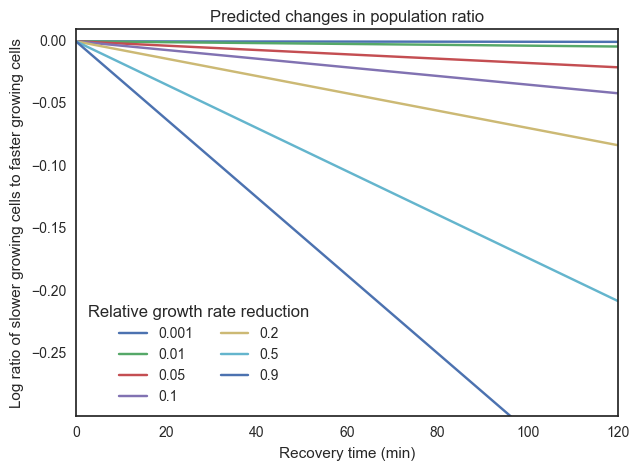

In [3]:
f,ax = plt.subplots(figsize = (7,5))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, np.log(s), label=str(percent_differences[i]))

ax.set_ylim((-.3,.01))
ax.legend(loc = 'lower left', fancybox=True, title = "Relative growth rate reduction", ncol=2)
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Log ratio of slower growing cells to faster growing cells')
ax.set_title('Predicted changes in population ratio')
plt.show()

Now lets add some sampling noise - we'll simulate this by drawing from a binomial distribution with frequency parameter equal to the frequencies given by the above.

**NOTE** The binomial distribution assumes sampling with replacement; however we can make this assumption because the population as a whole is considered to be functionally infinite compared to the sample we are taking.

In [4]:
timepoints = [30, 60, 90, 120]
sample_size = 20000

measured_ratios = []
for i, s in enumerate(ss):
    ratios = []
    for time in timepoints:
        p = predicted_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p)
        #print(sampled_wt)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        #print(measured_ratio)
        ratios.append(measured_ratio)
    measured_ratios.append(ratios)

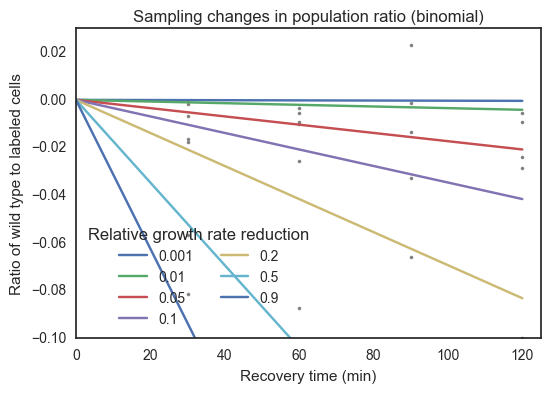

In [5]:
f,ax = plt.subplots(figsize = (6,4))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, np.log(s), label=str(percent_differences[i]))
    ax.scatter(timepoints, np.log(measured_ratios[i]), marker='.', color = 'gray')
    
    
#ax.set_ylim((.9,1.3))
ax.set_xlim((0,125))
ax.set_ylim((-.1,0.03))
ax.legend(loc = 'lower left', fancybox=True, title = "Relative growth rate reduction", ncol=2)
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Ratio of wild type to labeled cells')
ax.set_title('Sampling changes in population ratio (binomial)')
plt.show()

It seems pretty clear that we can distinguish large growth defects (50% and 10%) but what about less than 5%? Lets get a handle on the error due to sampling. We'll use the sampling scheme above, and calculate the expected distribution if the measurement is repeated 10 times.

In [46]:
index_lim = [1,3]
small_ss = ss[index_lim[0]:index_lim[1]]
small_freq = predicted_freq[index_lim[0]:index_lim[1]]
small_ratio = predicted_ratio[index_lim[0]:index_lim[1]]

predicted_dists = []
for i, s in enumerate(small_ss):
    ratios = []
    for time in timepoints:
        p = small_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p, 100)
        measured_ratio = np.log(sampled_wt / (sample_size - sampled_wt))
        ratios.append(measured_ratio)
    predicted_dists.append(ratios)

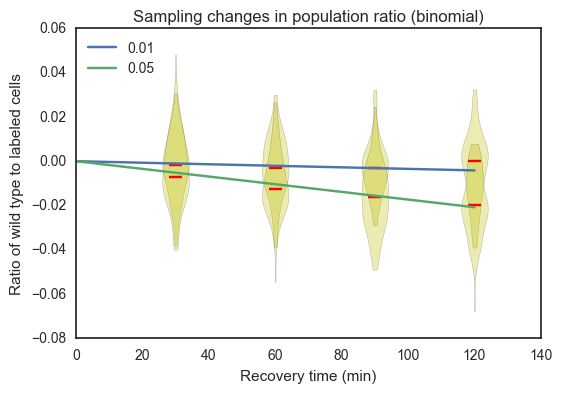

In [47]:
colors = ["black", "grey", "purple"]
f,ax = plt.subplots(figsize = (6,4))
for i, s in enumerate(small_ratio):
    #FIX MANUAL INDEXING OF LABELS
    ax.plot(t, np.log(s), label=str(percent_differences[i+1]))
    ax.violinplot(predicted_dists[i], positions=timepoints, widths=8, showmedians=True, showextrema=False)

ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Ratio of wild type to labeled cells')
ax.set_title('Sampling changes in population ratio (binomial)')
plt.legend(loc='upper left')
plt.show()

0.1% and 1% differences are nearly undetectable during this time period, although the median value for 5% seems reliably higher, enough to potentially measure accurately. This value could also be improved by improving sampling the distribution more; i.e. by recording more events. The trade-off here is that the increased time for sampling increases the amount of time between timepoints.

First I want to look at how the variance of the binomial scales with the probability of success (p) and the number of samples (n). It may be possible to increase the accuracy of our measure simply by optimizing these parameters. The variance of the binomial distribution is given by $np(1-p)$

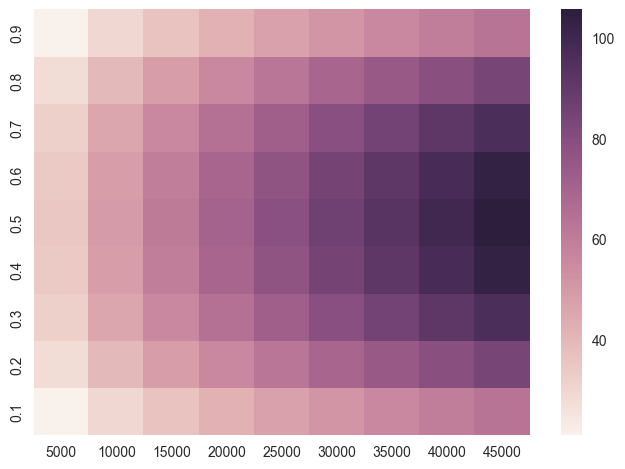

In [38]:
ps = 1-np.arange(0.1, 1, 0.1)
ns = np.arange(5000, 50000, 5000)

vs = []
for p in ps:
    v = ns*p*(1-p)
    vs.append(v)

vs = np.sqrt(np.array(vs))

ax = sns.heatmap(vs, xticklabels=ns, yticklabels=ps)
plt.show()

For any given n, the variance is maximal when the cells are in roughly equal proportion. Will reducing the variance help in getting a more accurate estimate of the ratio between the two populations? We know that if we have an estimate for $p$, the true frequency of the labeled cells (denoted by $\hat p$), then we can assess a confidence interval for this estimate (based on the assumption of binomially distributed number of successes):

\begin{equation}
    \hat p - z_{\frac{\alpha}{2}}\sqrt{\frac{\hat p \hat q}{n}} \leq p \leq \hat p + z_{\frac{\alpha}{2}}\sqrt{\frac{\hat p \hat q}{n}}
\end{equation}

the ratio $\log\left(\frac{p}{q}\right) = \log{r}$ can be calculated from p; $r = \frac{p}{(1-p)}$.

Now: how to assign a confidence interval for the quantity $\log\left(\frac{p}{q}\right)$?

In [ ]:
# Note that the equivalent of qnorm in R (which calculates the z values above) is scipy.stats.norm.ppf()